In [36]:
import zipfile
import os

# 압축 파일 경로
zip_path = '/content/archive.zip'
extract_to = '/content/brain_tumor_dataset'

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# 압축 해제 결과 확인
print("Extracted files:", os.listdir(extract_to))


Extracted files: ['brain_tumor_dataset', 'no', 'yes']


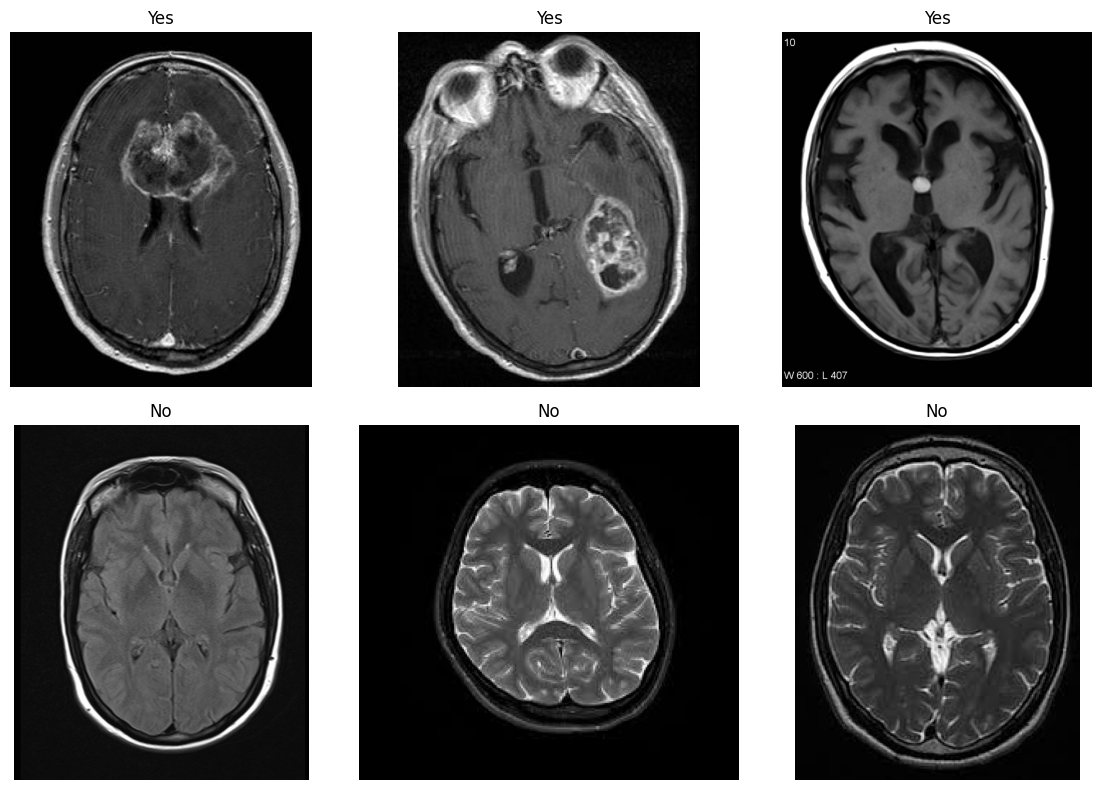

In [37]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# 폴더 경로 설정
yes_dir = '/content/brain_tumor_dataset/yes'
no_dir = '/content/brain_tumor_dataset/no'

# 샘플 이미지 선택
yes_samples = [os.path.join(yes_dir, f) for f in os.listdir(yes_dir) if f.endswith('.jpg')][:3]
no_samples = [os.path.join(no_dir, f) for f in os.listdir(no_dir) if f.endswith('.jpg')][:3]

# 이미지 시각화
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, img_path in enumerate(yes_samples + no_samples):
    img = Image.open(img_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Yes" if i < 3 else "No")

plt.tight_layout()
plt.show()


In [38]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 데이터 변환
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 흑백으로 변환
    transforms.Resize((128, 128)),               # 크기 조정
    transforms.RandomHorizontalFlip(p=0.5),     # 50% 확률로 좌우 반전
    transforms.RandomRotation(15),             # -15 ~ +15도 사이에서 랜덤 회전
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 랜덤 위치 이동
    transforms.ColorJitter(brightness=0.2, contrast=0.2),      # 밝기 및 대비 변화
    transforms.ToTensor(),                      # 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))        # 정규화
])



# 데이터셋 로드
data_dir = '/content/brain_tumor_dataset/brain_tumor_dataset'
train_data = datasets.ImageFolder(data_dir, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# 클래스 확인
print(f"Classes: {train_data.classes}")  # ['no', 'yes']
print(f"Number of samples: {len(train_data)}")


Classes: ['no', 'yes']
Number of samples: 253


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Conv Layer 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Conv Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Fully Connected Layer 1
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가 (50%)
        # Fully Connected Layer 2 (output layer)
        self.fc2 = nn.Linear(128, 2)  # 두 클래스 (yes/no)

    def forward(self, x):
        # Convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten
        x = x.view(-1, 64 * 32 * 32)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x)
        return x


# 모델 초기화
model = CNNModel()

# 모델 구조 확인
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [40]:
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# 하이퍼파라미터 설정
batch_size = 16
epochs = 30
learning_rate = 0.0005

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 데이터셋을 학습용과 검증용으로 나누기 (8:2 비율)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# 데이터 로더 설정
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 학습 루프
for epoch in range(epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    for inputs, labels in train_loader:
        # 데이터를 GPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 모델 예측
        outputs = model(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()

        # 손실 기록
        running_loss += loss.item()

    # 에폭별 손실 출력
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

    # 검증
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 검증 시 그래디언트 계산 안 함
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 검증 정확도 출력
    print(f"Validation Accuracy: {100 * correct / total}%\n")


Epoch [1/30], Loss: 1.1633150623394892
Validation Accuracy: 58.8235294117647%

Epoch [2/30], Loss: 0.6507648963194627
Validation Accuracy: 62.745098039215684%

Epoch [3/30], Loss: 0.6273421232516949
Validation Accuracy: 70.58823529411765%

Epoch [4/30], Loss: 0.6079945701819199
Validation Accuracy: 84.31372549019608%

Epoch [5/30], Loss: 0.5886575487943796
Validation Accuracy: 80.3921568627451%

Epoch [6/30], Loss: 0.5646197383220379
Validation Accuracy: 82.3529411764706%

Epoch [7/30], Loss: 0.5524815687766442
Validation Accuracy: 78.43137254901961%

Epoch [8/30], Loss: 0.4942993384141188
Validation Accuracy: 84.31372549019608%

Epoch [9/30], Loss: 0.5418078899383545
Validation Accuracy: 80.3921568627451%

Epoch [10/30], Loss: 0.5219504879071162
Validation Accuracy: 78.43137254901961%

Epoch [11/30], Loss: 0.5484612652888665
Validation Accuracy: 80.3921568627451%

Epoch [12/30], Loss: 0.4895456089423253
Validation Accuracy: 80.3921568627451%

Epoch [13/30], Loss: 0.5004398570610926
Va

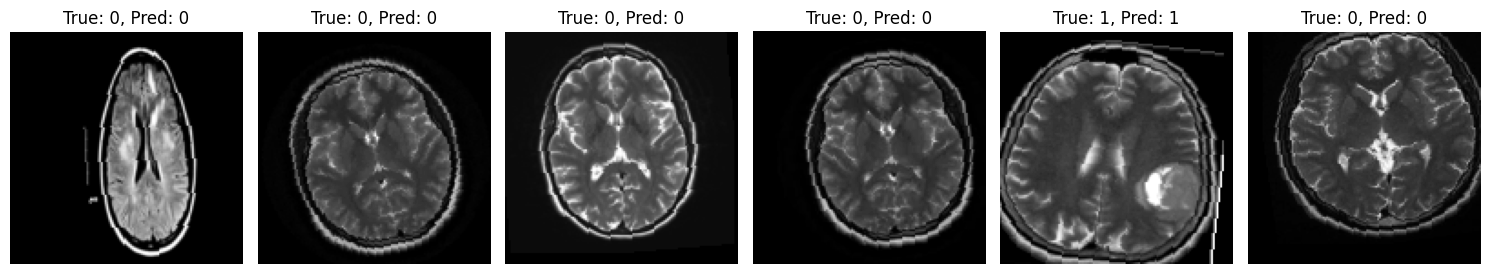

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 검증 데이터에서 랜덤 배치 예측
model.eval()
random_inputs, random_labels = next(iter(val_loader))  # 무작위 배치 가져오기
random_inputs, random_labels = random_inputs.to(device), random_labels.to(device)
outputs = model(random_inputs)
_, predictions = torch.max(outputs, 1)

# 무작위로 6개 선택
indices = np.random.choice(len(random_inputs), 6, replace=False)  # 6개 랜덤 인덱스 선택

# 랜덤 샘플 시각화
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i, idx in enumerate(indices):
    img = random_inputs[idx].cpu().squeeze()  # 이미지를 CPU로 이동하고 차원 축소
    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"True: {random_labels[idx].item()}, Pred: {predictions[idx].item()}")
plt.tight_layout()
plt.show()


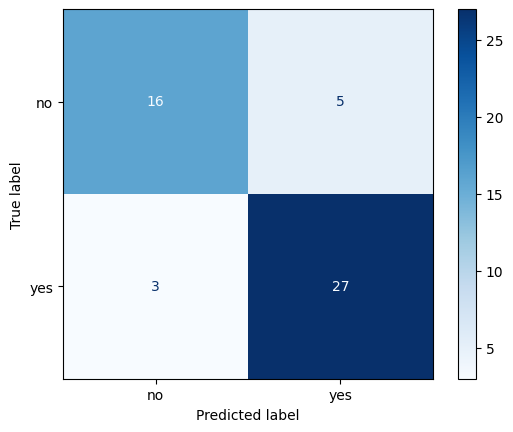

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

# 모델 평가 모드로 전환
model.eval()

# 예측 결과 및 실제 레이블 수집
all_predictions = []
all_labels = []

# 검증 데이터셋에 대해 예측
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_labels.extend(labels.cpu().numpy())          # 실제 레이블 저장

# 혼동행렬 계산
cm = confusion_matrix(all_labels, all_predictions)

# ConfusionMatrixDisplay 생성
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.dataset.classes)

# 혼동행렬 시각화
disp.plot(cmap='Blues')
plt.show()
